# Dr. Frank's 2020 Election Analysis for Ohio -- Single County

Based on Robert Lee's Python code from [his github repo](https://github.com/rlee32/election-fraud-ohio).

**Aggregate Voters by Age**

Show "turnout" that is the "normalized" fraction of voters by age.

The "normalization" is the ratio by age of those voting compared to registered voters.

efg, 2022-04-07

Assumes setup script already run:  `Ohio-Analysis-1.ipynb`

In [1]:
import datetime
start_time = datetime.datetime.now()
print (start_time)

2022-04-07 00:49:40.832645


In [2]:
import os
import sys
import json

import pandas as pd

from matplotlib import pyplot as plt   
%matplotlib inline

Ohio County codes

In [3]:
OhioCounty = pd.read_csv("Ohio-Codes.csv")
print(OhioCounty)

    Code      County
0      1       Adams
1      2       Allen
2      3     Ashland
3      4   Ashtabula
4      5      Athens
..   ...         ...
83    84  Washington
84    85       Wayne
85    86    Williams
86    87        Wood
87    88     Wyandot

[88 rows x 2 columns]


In [4]:
OhioCounty.dtypes

Code       int64
County    object
dtype: object

# 1. Setup

Adapted from script `plot_turnout_by_age.py`

In [5]:
TOTAL_COUNTIES = 88  
JSON_FOLDER    = './jsonified/' 

In [6]:
ELECTION_YEAR = 2020 # choose presidential election years from 2000 - 2020

ELECTION_DAY = {
    2020: '03',
    2016: '08',
    2012: '06',
    2008: '04',
    2004: '02',
    2000: '07'
}

ELECTION_DATE = f'{ELECTION_YEAR}-11-{ELECTION_DAY[ELECTION_YEAR]}'
ELECTION_FIELD = f'general_{ELECTION_YEAR}'      

In [7]:
ELECTION_DATE

'2020-11-03'

In [8]:
ELECTION_FIELD

'general_2020'

## 1.1 "Helper" functions

In [9]:
def str_to_int(date):
    """Converts date in form YYYY-MM-DD to and integer of form YYYYMMDD. """
    return int(date.replace('-', ''))   

In [10]:
def get_age(start_date, end_date):
    """Returns integer age given dates in form YYYY-MM-DD. """
    start = str_to_int(start_date)
    end = str_to_int(end_date)
    diff = end - start
    if diff < 0:
        return diff / 10000.0
    else:
        return int(diff / 10000)         

In [11]:
def votes_by_age(county_id: int):
    """Reads voter data in json format and outputs votes aggregated by age for the specified election. """
    data = json.load(open(f'{JSON_FOLDER}/{county_id}.json', 'r'))
    by_age = {}
    for d in data:
        registration_age = get_age(d['registration_date'], ELECTION_DATE)
        if registration_age < 0:
            continue
            
        age = get_age(d['date_of_birth'], ELECTION_DATE)
        if age < 18:
            print(f'skipping underage {age}; data: {d}')
            continue
            
        if age > 105:    # lower this from 150 to 105
            print(f'skipping unreasonable age {age}; data: {d}')
            continue
            
        if age not in by_age:
            by_age[age] = {'registered': 0, 'voted': 0, 'active': 0}
            
        by_age[age]['registered'] += 1
        
        if d["voter_status"] == "ACTIVE":   
            by_age[age]['active'] += 1
            
        if d[ELECTION_FIELD].strip():
            by_age[age]['voted'] += 1
    return by_age                         

# 2. Single County Plot

## 2.1 Registered, Active, Voted in 2020 by Age

See:

* Map [Ohio Counties w/County Codes](https://jfs.ohio.gov/PerformanceCenter/FastFacts/Ohio_Counties_with_County_Codes.pdf) 

* Table [Ohio Counties with County Number](https://tax.ohio.gov/static/excise/Ohio%20County%20Listing.pdf)

In [12]:
county_id = 5   # 1 .. 88    Franklin County (25) is largest and very young compared to next largest Cuyahoga (18)

In [13]:
CountyName = OhioCounty.loc[OhioCounty['Code'] == county_id].County.values[0]

In [14]:
by_age = votes_by_age(county_id)

skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '2014-08-04', 'voter_status': 'CONFIRMATION', 'general_2000': '', 'general_2016': '', 'general_2020': '', 'general_2004': '', 'general_2008': '', 'general_2012': ''}
skipping unreasonable age 220; data: {'date_of_birth': '1800-01-01', 'registration_date': '1965-09-22', 'voter_status': 'ACTIVE', 'general_2000': 'X', 'general_2016': '', 'general_2020': '', 'general_2004': 'X', 'general_2008': 'X', 'general_2012': 'X'}


In [15]:
sorted_by_age = list(by_age.items())
sorted_by_age.sort()

In [16]:
age        = [x[0]                       for x in sorted_by_age]
registered = [by_age[x[0]]['registered'] for x in sorted_by_age]
active     = [by_age[x[0]]['active']     for x in sorted_by_age]
voted      = [by_age[x[0]]['voted']      for x in sorted_by_age]

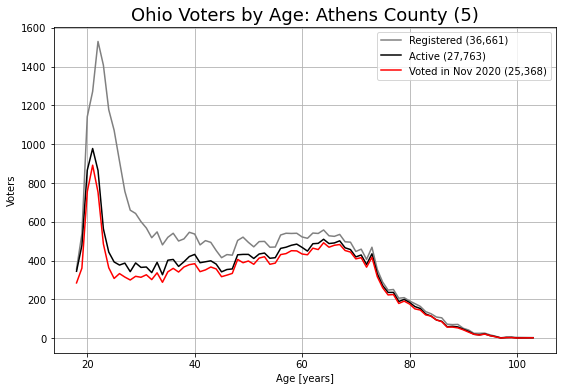

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.plot(age, registered, color = "grey",   label = f'Registered ({sum(registered):,})')
plt.plot(age, active,     color = "black",  label = f'Active ({sum(active):,})')
plt.plot(age, voted,      color = "red",    label = f'Voted in Nov 2020 ({sum(voted):,})')

ax.legend()
ax.set(xlabel = 'Age [years]', ylabel = 'Voters')
ax.set_title(f'Ohio Voters by Age: {CountyName} County ({county_id})', fontsize = 18)

plt.grid()
plt.show()      

## 2.2 Turnout by Age

Make grey Registered Voter line = 100%

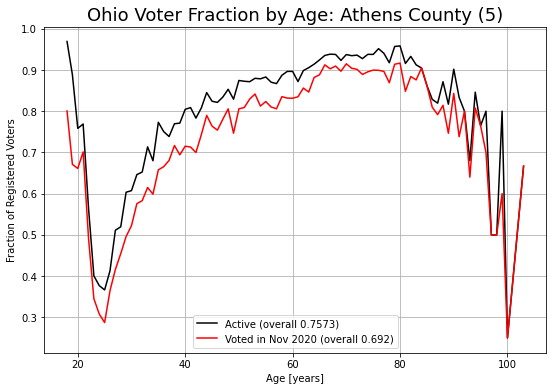

In [18]:
fraction_active = [active[i] / registered[i]  for i in range(len(registered))]
fraction_voted  = [voted[i]  / registered[i]  for i in range(len(registered))]

overall_fraction_active = sum(active) / sum(registered)
overall_fraction_voted  = sum(voted)  / sum(registered)

fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(age, fraction_active, color ="black", label = f'Active (overall {overall_fraction_active:.4})')
plt.plot(age, fraction_voted,  color ="red",   label = f'Voted in Nov 2020 (overall {overall_fraction_voted:.4})')

ax.legend()
ax.set(xlabel = 'Age [years]', ylabel = 'Fraction of Registered Voters')
ax.set_title(f'Ohio Voter Fraction by Age: {CountyName} County ({county_id})', fontsize = 18)

plt.grid()
plt.show()

## 2.3 'Normalized' Turnout by Age (`Key`)

Normalization is ratio of turnout by age to average for all ages.

What is the intuituion for this normalization?  

* Normalized fraction < 1 shows ages that "underperformed"
* Normalized fraction > 1 shows ages that "outperformed"

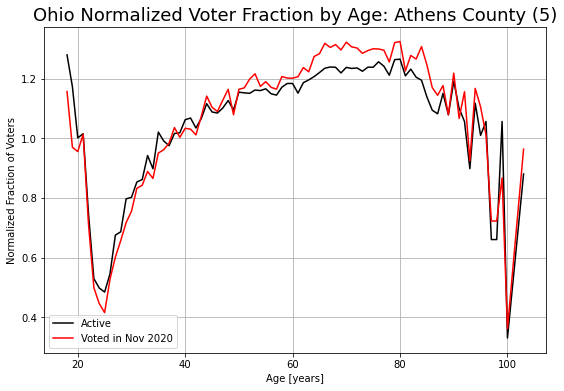

In [19]:
fraction_active_normalized  = [fraction_active[i] / overall_fraction_active for i in range(len(registered))]
fraction_voted_normalized   = [fraction_voted[i]  / overall_fraction_voted  for i in range(len(registered))]


fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(age, fraction_active_normalized, color ="black", label = f'Active')
plt.plot(age, fraction_voted_normalized,  color ="red",   label = f'Voted in Nov 2020')

ax.legend()
ax.set(xlabel = 'Age [years]', ylabel = 'Normalized Fraction of Voters')
ax.set_title(f'Ohio Normalized Voter Fraction by Age: {CountyName} County ({county_id})', fontsize = 18)

plt.grid()
plt.show()

Show `key` values here for verification purposes.

In [20]:
print(fraction_voted_normalized)

[1.1569456034143697, 0.9697125231096403, 0.9554301142523559, 1.0134348180940085, 0.7112489256188126, 0.49882899850563345, 0.4453273953415905, 0.4152159319297552, 0.5270982010090763, 0.6013575284103336, 0.6568941544107108, 0.7169647240520012, 0.7550457269000316, 0.8319888286673685, 0.8425491818348961, 0.888725047591425, 0.8652975805293687, 0.9504753111127283, 0.9616639007269554, 0.9836367158461381, 1.0358912895922028, 1.0031471537502759, 1.0334156082796433, 1.0305453823665744, 1.0113296882219769, 1.0736363163384774, 1.1414262585711774, 1.1038987549060957, 1.0897432027927103, 1.1277706183667997, 1.1641624180945374, 1.0790211465349064, 1.1643249425142073, 1.1690205524990611, 1.1985020656577747, 1.2163731436382699, 1.174005714769846, 1.1899567724793172, 1.1708027015267592, 1.1646818353248682, 1.2069821851968652, 1.2020798759086944, 1.2015374303282502, 1.2066444079078298, 1.2371910568679954, 1.2230395978602382, 1.2742333919966904, 1.2836806600775972, 1.3185429712723942, 1.3047022962183574, 

In [21]:
stop_time = datetime.datetime.now()
print (stop_time)
print ((stop_time - start_time), "elapsed time")

2022-04-07 00:49:51.330059
0:00:10.497414 elapsed time
